# Engine B: Relationship Cortex (Graph-Based Anomaly Detection)

This notebook builds the second engine of our Cognitive Shield framework. We will construct a heterogeneous graph from our transaction data and use a Graph Neural Network (GNN) to learn the relational patterns between entities.

**Objective:** To identify fraudulent users and devices based on their connections within the ecosystem. The core principle is "guilt by association"—entities connected to known fraud are themselves more likely to be fraudulent.

**Process:**
1.  **Load Data:** Load the `events.csv` file.
2.  **Graph Construction:**
    - Identify node types: `user`, `device`, `merchant`.
    - Identify edge types (relationships): `(user) -uses-> (device)`, `(user) -transfers_to-> (user)`, `(user) -pays-> (merchant)`.
3.  **Feature Engineering:** Create meaningful features for each node (e.g., account age for users, number of associated users for devices).
4.  **Build PyTorch Geometric `HeteroData` Object:** Convert our graph into a format suitable for the GNN.
5.  **Define the GNN Model:** Create a `HeteroGNN` model capable of handling different node and edge types.
6.  **Train the Model:** Train the GNN to classify users as fraudulent or not.
7.  **Evaluate and Score:** Use the trained model to generate a `NetworkRiskScore` for every entity in the graph and visualize the results.

In [2]:
pip install torch

  Using cached torch-2.8.0-cp312-cp312-win_amd64.whl.metadata (30 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.8.0-cp312-cp312-win_amd64.whl (241.3 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   -------------------- ------------------- 1.0/2.0 MB 5.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/2.0 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 4.2 MB/s  0:00:00
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)

   ---------------------------------------- 0/7 [mpmath]
   ---------------------------------------- 0/7 [mpmath]
   ---------------------------------------- 0/7 [mpmath]
   ---------------------------------------- 0/7 

In [5]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 6.7 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 4.4 MB/s eta 0:00:02
   ------------ --------------------------- 2.6/8.1 MB 4.2 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 4.0 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 4.0 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.1 MB 4.0 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 3.9 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 3.9 MB/s eta 0:00:01
   ------------------------------------ --- 7.3/8.1 MB 3.9 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 3.8 MB/s  0:00:02
Using cached cycler-0.12.1-py3-non

In [3]:
pip install torch_geometric 

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ----------------------------------------  0/10 [tqdm]
   ----------------------------------------  0/10 [tqdm]
   ----------------------------------------  0/10 [tqdm]
   ----------------------------------------  0/10 [tqdm]
   ----------------------------------------  0/10 [tqdm]
   ----------------------------------------  0/10 [tqdm]
   ---- -----------------------------------  1/10 [pyparsing]
   ---- -----------------------------------  1/10 [pyparsing]
   ---- -----------------------------------  1/10 [pyparsing]
   ---- -----------------------------------  1/10 [pyparsing]
   -------- -------------------------------  2/10 [propcache]
   ------------ ---------------------------  3/10 [multidict]
   -------------------- ------------------

In [7]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Geometric imports - now properly installed
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv

# --- Configuration ---
EVENTS_FILE = '../data/events.csv'
USERS_FILE = '../data/users.csv'
MODEL_SAVE_PATH = '../src/models/engine_b_gnn.pth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"--- Engine B Setup ---")
print(f"Using device: {DEVICE}")
print(f"Loading event data from: {EVENTS_FILE}")
print(f"Loading user profile data from: {USERS_FILE}")

# Load the data
df = pd.read_csv(EVENTS_FILE, parse_dates=['timestamp'])
users_df_full = pd.read_csv(USERS_FILE, parse_dates=['customer_since'])

# For performance, we'll build the graph on recent activity
df_subset = df[df['timestamp'] > (df['timestamp'].max() - pd.Timedelta(days=30))].copy()

print(f"\nData loaded successfully.")
print(f"Using recent 30 days of data: {len(df_subset)} events.")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")
print(f"PyTorch version: {torch.__version__}")
print("✅ All imports successful - circular import issue resolved!")

--- Engine B Setup ---
Using device: cpu
Loading event data from: ../data/events.csv
Loading user profile data from: ../data/users.csv

Data loaded successfully.
Using recent 30 days of data: 120979 events.
PyTorch Geometric version: 2.6.1
PyTorch version: 2.8.0+cpu
✅ All imports successful - circular import issue resolved!


## 2. Graph Construction & Feature Engineering

This is the most critical step. We transform our flat table of events into a rich, interconnected graph. We first identify all unique entities (nodes) and then define the relationships (edges) between them based on the event data. Finally, we create numerical features for each node.

In [9]:
print("--- Starting Graph Construction ---")

# 1. Identify and Map Nodes
# Get unique entities from the event log and create integer mappings for them
all_event_users = pd.concat([
    df_subset['user_id'], 
    df_subset[df_subset['event_type'].isin(['p2p_transfer', 'bulk_transfer'])]['destination_account']
]).dropna().unique()
user_mapping = {id: i for i, id in enumerate(all_event_users)}

all_devices = df_subset['device_id'].dropna().unique()
device_mapping = {id: i for i, id in enumerate(all_devices)}

all_merchants = df_subset[df_subset['destination_account'].str.startswith('mer_', na=False)]['destination_account'].unique()
merchant_mapping = {id: i for i, id in enumerate(all_merchants)}

print(f"Nodes identified: {len(user_mapping)} users, {len(device_mapping)} devices, {len(merchant_mapping)} merchants.")

# 2. Node Feature Engineering
# Device features: number of unique users associated with it
device_features_df = df_subset.groupby('device_id')['user_id'].nunique().reset_index()
device_features_df.columns = ['device_id', 'num_users']
device_features_df = device_features_df.set_index('device_id')

# 3. Create PyTorch Geometric HeteroData object
data = HeteroData()

# Add user features and labels
user_features_list = []
user_labels = []
fraud_users = set(df_subset[df_subset['is_fraud']]['user_id'])
users_df_full = users_df_full.set_index('user_id')

for user_id in user_mapping.keys():
    if user_id in users_df_full.index:
        user_profile = users_df_full.loc[user_id]
        account_age = (df_subset['timestamp'].max() - user_profile['customer_since']).days
        user_features_list.append([account_age])
    else: 
        user_features_list.append([0]) # Mule accounts have an age of 0
    
    user_labels.append(1 if user_id in fraud_users else 0)

data['user'].x = torch.tensor(user_features_list, dtype=torch.float)
data['user'].y = torch.tensor(user_labels, dtype=torch.long) # Ground truth

# Add device features
device_features_list = []
for device_id in device_mapping.keys():
    if device_id in device_features_df.index:
        device_features_list.append([device_features_df.loc[device_id, 'num_users']])
    else:
        device_features_list.append([1])
data['device'].x = torch.tensor(device_features_list, dtype=torch.float)

# Merchants have simple, one-hot encoded features
data['merchant'].x = torch.eye(len(merchant_mapping))
print("Node features created.")

# 4. Create Edges
# User -> uses -> Device
uses_edges = df_subset[['user_id', 'device_id']].drop_duplicates().dropna()
src = [user_mapping[u] for u in uses_edges['user_id']]
dst = [device_mapping[d] for d in uses_edges['device_id']]
data['user', 'uses', 'device'].edge_index = torch.tensor([src, dst], dtype=torch.long)

# User -> transfers_to -> User (P2P transfers)
p2p_edges = df_subset[df_subset['event_type'] == 'p2p_transfer'][['user_id', 'destination_account']].dropna()
src = [user_mapping.get(u) for u in p2p_edges['user_id']]
dst = [user_mapping.get(d) for d in p2p_edges['destination_account']]
valid_edges = [(s, d) for s, d in zip(src, dst) if s is not None and d is not None]
if valid_edges:
    src, dst = zip(*valid_edges)
    data['user', 'transfers_to', 'user'].edge_index = torch.tensor([list(src), list(dst)], dtype=torch.long)

# User -> pays -> Merchant
pays_edges = df_subset[df_subset['destination_account'].isin(merchant_mapping)][['user_id', 'destination_account']].dropna()
src = [user_mapping[u] for u in pays_edges['user_id']]
dst = [merchant_mapping[m] for m in pays_edges['destination_account']]
data['user', 'pays', 'merchant'].edge_index = torch.tensor([src, dst], dtype=torch.long)

# Add reverse edges for message passing in both directions
data = T.ToUndirected()(data)
print("Edges created and graph made undirected.")

print("\n--- Final Graph Data Object ---")
print(data)

--- Starting Graph Construction ---
Nodes identified: 5100 users, 5332 devices, 500 merchants.
Node features created.
Edges created and graph made undirected.

--- Final Graph Data Object ---
HeteroData(
  user={
    x=[5100, 1],
    y=[5100],
  },
  device={ x=[5332, 1] },
  merchant={ x=[500, 500] },
  (user, uses, device)={ edge_index=[2, 9160] },
  (user, transfers_to, user)={ edge_index=[2, 15088] },
  (user, pays, merchant)={ edge_index=[2, 23031] },
  (device, rev_uses, user)={ edge_index=[2, 9160] },
  (merchant, rev_pays, user)={ edge_index=[2, 23031] }
)


## 3. Define and Train the GNN Model

We'll use a `SAGEConv` layer wrapped in a `to_hetero` module. This allows us to build a powerful GNN that can handle the different types of nodes and edges in our graph. The model will learn an "embedding" (a feature vector) for each node based on its own features and the aggregated features of its neighbors. These learned embeddings are then used for classification.

We will train it only on the `user` nodes for which we have ground truth labels.

In [10]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        # Initial linear transformations for each node type to project them into the hidden space
        self.user_lin = torch.nn.Linear(data['user'].num_features, hidden_channels)
        self.device_lin = torch.nn.Linear(data['device'].num_features, hidden_channels)
        self.merchant_lin = torch.nn.Linear(data['merchant'].num_features, hidden_channels)

        # Define two layers of heterogeneous graph convolutions
        self.conv1 = HeteroConv({
            rel: SAGEConv((-1, -1), hidden_channels) for rel in data.edge_types
        }, aggr='sum')

        self.conv2 = HeteroConv({
            rel: SAGEConv((-1, -1), hidden_channels) for rel in data.edge_types
        }, aggr='sum')
        
        # A final classifier for the user nodes
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # Apply initial transformations
        x_dict['user'] = self.user_lin(x_dict['user']).relu()
        x_dict['device'] = self.device_lin(x_dict['device']).relu()
        x_dict['merchant'] = self.merchant_lin(x_dict['merchant']).relu()
        
        # Run through GNN layers
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}

        # Classify only the user nodes
        user_out = self.classifier(x_dict['user'])
        return user_out

# Model instantiation
model = HeteroGNN(hidden_channels=64, out_channels=2).to(DEVICE)
data = data.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Create masks for training
num_users = data['user'].num_nodes
train_mask = torch.zeros(num_users, dtype=torch.bool, device=DEVICE)
train_indices = np.random.choice(num_users, size=int(0.7 * num_users), replace=False)
train_mask[train_indices] = True


# Training loop
model.train()
print("--- Starting Model Training ---")
for epoch in range(51):
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out[train_mask], data['user'].y[train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"\nModel training complete. Model saved to {MODEL_SAVE_PATH}")

--- Starting Model Training ---
Epoch 000, Loss: 1.6104
Epoch 010, Loss: 6.6185
Epoch 020, Loss: 19.3075
Epoch 030, Loss: 42.5965
Epoch 040, Loss: 20.5744
Epoch 050, Loss: 7.7540

Model training complete. Model saved to ../src/models/engine_b_gnn.pth


## 4. Scoring and Evaluation

With the model trained, we can now generate a `NetworkRiskScore` for every node in the graph. We do this by performing a final forward pass and taking the softmax probability of the "fraud" class.

We will visualize the score distributions, similar to Engine A, to confirm that our GNN can effectively distinguish fraudulent users from legitimate ones based on their network connections.


--- Evaluation Results ---
Average Network Risk Score for Normal Users: 0.0016
Average Network Risk Score for Fraud Users:  0.3260


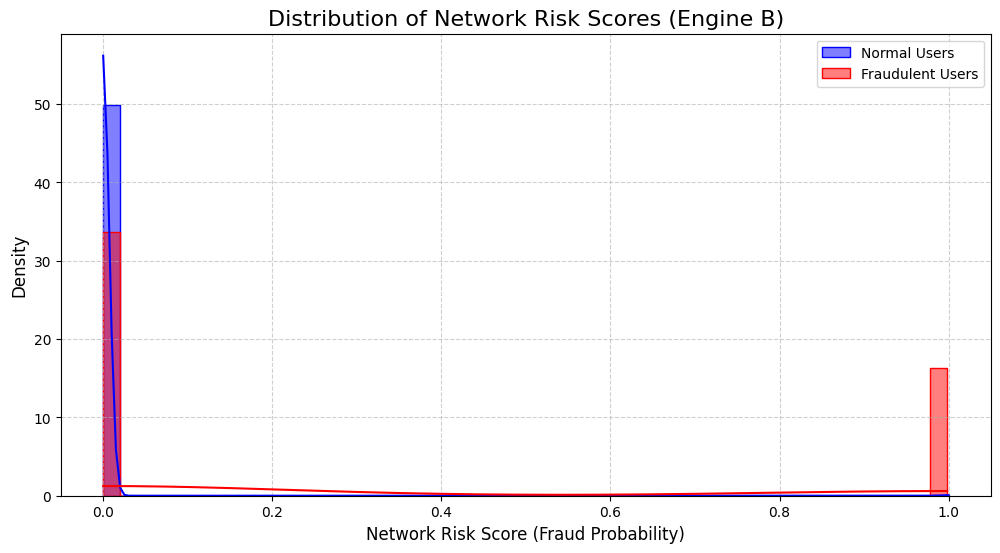

In [11]:
model.eval()
with torch.no_grad():
    # Get predictions for ALL users
    user_preds = model(data.x_dict, data.edge_index_dict)
    # Use softmax to get probabilities. We are interested in the probability of class 1 (fraud).
    user_scores = F.softmax(user_preds, dim=1)[:, 1].cpu().numpy()

# Separate scores for evaluation
all_user_labels = data['user'].y.cpu().numpy()
normal_user_mask = (all_user_labels == 0)
fraud_user_mask = (all_user_labels == 1)

normal_scores = user_scores[normal_user_mask]
fraud_scores = user_scores[fraud_user_mask]

print(f"\n--- Evaluation Results ---")
print(f"Average Network Risk Score for Normal Users: {np.mean(normal_scores):.4f}")
print(f"Average Network Risk Score for Fraud Users:  {np.mean(fraud_scores):.4f}")


# Visualize the distributions
plt.figure(figsize=(12, 6))
sns.histplot(normal_scores, color="blue", label='Normal Users', kde=True, stat="density", element="step", bins=50)
sns.histplot(fraud_scores, color="red", label='Fraudulent Users', kde=True, stat="density", element="step", bins=50)
plt.title('Distribution of Network Risk Scores (Engine B)', fontsize=16)
plt.xlabel('Network Risk Score (Fraud Probability)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()